In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torchvision import datasets
from torch.autograd import Variable
from torch import cuda
import copy
%matplotlib inline

In [2]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
train_dir='C:/Datasets/Alzheimer_s Dataset/train/'
test_dir='C:/Datasets/Alzheimer_s Dataset/test/'

In [4]:
from torchvision import transforms
from torch.utils.data import DataLoader

In [5]:
transform=transforms.Compose([
    transforms.CenterCrop(180),
    transforms.Resize(255),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

In [6]:
train_data=datasets.ImageFolder(train_dir,transform=transform)
test_data=datasets.ImageFolder(test_dir,transform=transform)

In [7]:
trainLoader=DataLoader(train_data,batch_size=50,shuffle=True)
testLoader=DataLoader(test_data,batch_size=50,shuffle=True)


In [8]:
images,labels=next(iter(trainLoader))
test_images,test_labels=next(iter(testLoader))

In [10]:
images.shape

torch.Size([50, 3, 255, 255])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<matplotlib.image.AxesImage at 0x27eae7b9e80>, tensor(2))

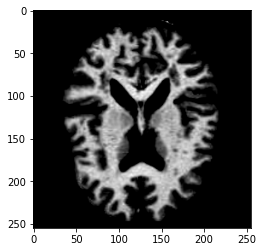

In [9]:
ID=7
plt.imshow(images[ID].permute(1,2,0)),labels[ID]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<matplotlib.image.AxesImage at 0x27eb087b160>, tensor(2))

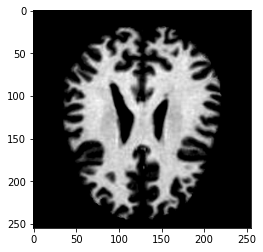

In [10]:
plt.imshow(test_images[ID].permute(1,2,0)),test_labels[ID]

In [11]:
train_data

Dataset ImageFolder
    Number of datapoints: 5121
    Root location: E:/Datasets/Alzheimer_s Dataset/train/
    StandardTransform
Transform: Compose(
               CenterCrop(size=(180, 180))
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [12]:
test_data

Dataset ImageFolder
    Number of datapoints: 1279
    Root location: E:/Datasets/Alzheimer_s Dataset/test/
    StandardTransform
Transform: Compose(
               CenterCrop(size=(180, 180))
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [13]:
import torch.nn as nn
import torch.nn.functional as F

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3,6,5)
        self.pool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(6,16,5)
        self.fc1=nn.Linear(16*60*60,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,4)
        self.softmax=nn.Softmax(dim=1)
        
    def forward(self,x):
        x=self.conv1(x)
        x=F.relu(x)
        x=self.pool(x)
        x=self.pool(F.relu(self.conv2(x)))
        x=torch.flatten(x,1)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x
cnn=CNN()  
if torch.cuda.is_available(): 
    cnn.cuda()

In [18]:
def mean(arr):
    return sum(arr)/len(arr)

def getAccuracy(images,labels):
    accuracy=[]
    for i in range(len(images)):
        if torch.argmax(images[i]).item()==labels[i].item():
            accuracy.append(1)
        else:
            accuracy.append(0)
    return sum(accuracy)/len(accuracy)

def getWeightsForCrossEntropy(data):
    '''
    Return a list of wights corresponding to each class present in training data.
    Args:
    
    data (torch.utils.data.Dataset): Dataset object from which classes can be derived
    '''
    classes,counts=torch.tensor(data.targets).unique(return_counts=True)
    maxClassSize=counts.min().item()
    weights=[maxClassSize/counts[i].item() for i in range(len(counts))]
    return torch.tensor(weights)

def train(trainLoader,model,optimizer,criterion):
    metrics={
        'Accuracy':[],
        'Loss':[]
    }
    for epoch in range(5):
        for images,labels in trainLoader:
            if torch.cuda.is_available():
                images=Variable(images.cuda())
                labels=Variable(labels.cuda())
            optimizer.zero_grad()
            outputs=model(images)
            loss=criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            metrics['Loss'].append(loss.item())
            accuracy=getAccuracy(outputs,labels)
            metrics['Accuracy'].append(accuracy)
        print('Accuracy/Epoch:',100*sum(metrics['Accuracy'])/len(metrics['Accuracy']))
        print('Loss/Epoch:',sum(metrics['Loss'])/len(metrics['Loss']))
    return metrics

def test(dataLoader,model,criterion):
    metrics={
        'val_loss':[],
        'val_accuracy':[]
    }
    with torch.no_grad():
        model.eval()
        for epoch in range(1):
            epoch_loss=0
            count=0
            for idx, data in enumerate(dataLoader):
                inputs,labels=data
                if torch.cuda.is_available():
                    inputs=Variable(inputs.cuda())
                    labels=Variable(labels.cuda())
                outputs=model(inputs.float())
                loss=criterion(outputs,labels)
                metrics['val_loss'].append(loss.item())
                metrics['val_accuracy'].append(getAccuracy(outputs,labels))
            print(f"Epoch:{epoch}\nMean Loss:{mean(metrics['val_loss'])}")
            print(f"Mean Accuracy:{100*mean(metrics['val_accuracy'])}\n")
    return metrics

In [19]:
criterion=nn.CrossEntropyLoss(getWeightsForCrossEntropy(train_data).cuda())
metrics=train(trainLoader,cnn,torch.optim.Adam(cnn.parameters()),criterion)

Accuracy/Epoch: 31.619972260748952
Loss/Epoch: 1.3814966505013624
Accuracy/Epoch: 34.944059177068894
Loss/Epoch: 1.3789709592328487
Accuracy/Epoch: 36.032362459546924
Loss/Epoch: 1.3788522424049747
Accuracy/Epoch: 35.04576976421637
Loss/Epoch: 1.378992086764678
Accuracy/Epoch: 34.395006934812784
Loss/Epoch: 1.378917805662433


In [20]:
val_metrics=test(testLoader,cnn,criterion)

Epoch:0
Mean Loss:1.3722295715258672
Mean Accuracy:35.12997347480106



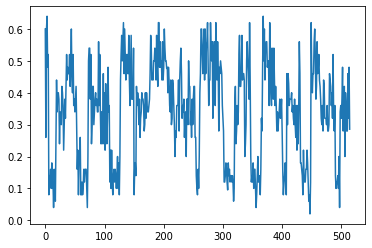

In [21]:
plt.plot(metrics['Accuracy'])

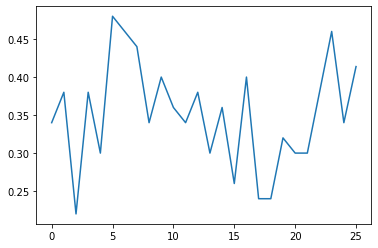

In [22]:
plt.plot(val_metrics['val_accuracy'])

c:\users\ashwin\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

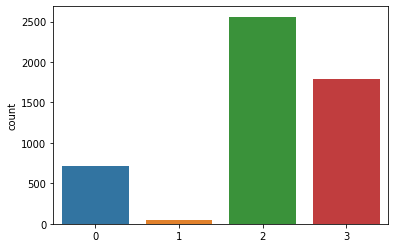

In [23]:
sns.countplot(train_data.targets)

In [ ]:
getWeightsForCrossEntropy(test_data)